In [1]:
from sklearn import svm
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [2]:
#General Imports
import csv
import math
import matplotlib.pyplot as plt
import pylab as pl

#ScikitLearn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split

#Qiskit imports
from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [3]:
# Constants
SEED = 2508


In [172]:
from qiskit import IBMQ
from qiskit.visualization import plot_error_map

In [5]:
# IBMQ.save_account('YOUR TOKEN HERE')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education',group='qscitech-quantum',project='qc-bc-workshop')

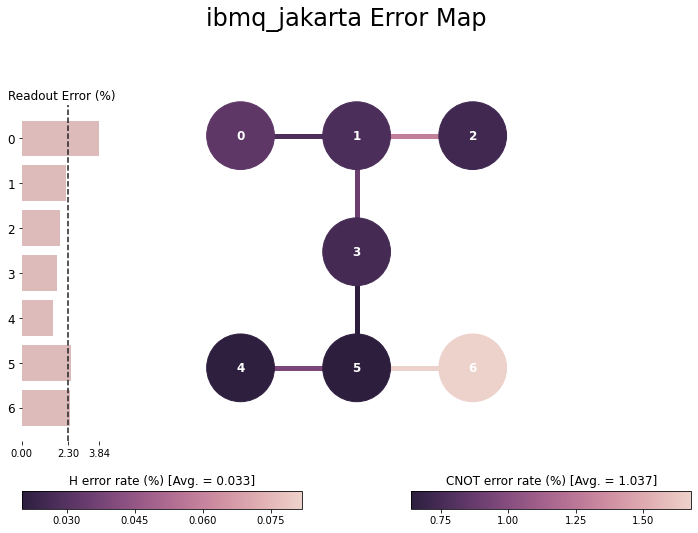

In [6]:
ibmq_jakarta = provider.get_backend('ibmq_jakarta')
plot_error_map(ibmq_jakarta)

# 1. Prepare Dataset

**Dataset Information:**
* Total examples: 1372 -- Dimensions: 5
* Training set [to train a model]: 
* (Validation set [to benchmark different models and choose the best performer]):
* Test set [to test actual performance of the best performer following validation]:

In [4]:
datafile = pd.read_csv("data_banknote_authentication.txt",header=None)
datafile

,0,1,2,3,4
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [5]:
data = datafile.to_numpy()
print(f'{data.shape} -- {data.shape[0]} examples ; {data.shape[1]} features')
# TODO: split the dataset to: Training set (100 points only), (Validation set), Test set
# TODO: might need to scale (or, normalize) the features -- explanation: in gradient-based ML, we want all features to be
# at the same scale (e.g., all between [-1,1]) to optimize learning performance.
# Here, we have features 1 and 2 can have value upto +/-20, which is very large compared to other features --> need scaling

(1372, 5) -- 1372 examples ; 5 features


In [6]:
xdata, ydata = np.hsplit(data, [4])
feature_dim=np.shape(xdata)[1]
print(f'{feature_dim} number of features')
xdata
ydata
print(f'{xdata.shape} -- {ydata.shape}')

4 number of features
(1372, 4) -- (1372, 1)


In [19]:
datafile_100 = pd.read_csv("banknote_auth_100.csv",header=0)
datafile_100

,variance,skewness,curtosis,entropy,class
0,-0.708670,-5.56020,4.04830,0.90300,1
1,-2.140500,-0.16762,1.32100,-0.20906,1
2,-0.626840,-6.30100,4.78430,1.10600,1
3,-2.226100,12.53980,2.94380,-3.52580,0
4,0.743070,11.17000,-1.38240,-4.07280,0
...,...,...,...,...,...
95,4.827800,7.75980,-2.44910,-1.22160,0
96,-3.408300,4.85870,-0.76888,-4.86680,1
97,2.916300,10.83060,-3.34370,-4.12200,0
98,0.030219,-1.05120,1.40240,0.77369,1


In [20]:
data_100 = datafile_100.to_numpy()
print(f'{data_100.shape} -- {data_100.shape[0]} examples ; {data_100.shape[1]} features')

(100, 5) -- 100 examples ; 5 features


In [82]:
xdata_100, ydata_100 = np.hsplit(data_100, [4])
feature_dim=np.shape(xdata_100)[1]
print(f'{feature_dim} number of features')
xdata_100
ydata_100
print(f'{xdata_100.shape} -- {ydata_100.shape}')

4 number of features
(100, 4) -- (100, 1)


In [7]:
test_ratio=0.9
seed=2456

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(xdata_100, ydata_100, test_size=test_ratio, random_state=seed)
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=test_ratio, random_state=seed)
print(f'{x_train.shape} -- {y_train.shape}')
print(f'{x_test.shape} -- {y_test.shape}')
#x_train[4]
print(y_train[4])
y_train = np.reshape(y_train, -1)
print(y_train[1])
y_test = np.reshape(y_test, -1)
print(xdata[0])

(137, 4) -- (137, 1)
(1235, 4) -- (1235, 1)
[0.]
0.0
[ 3.6216   8.6661  -2.8073  -0.44699]


# 2. VQC from scratch

## 2.1. Prepare encoders and ansatz

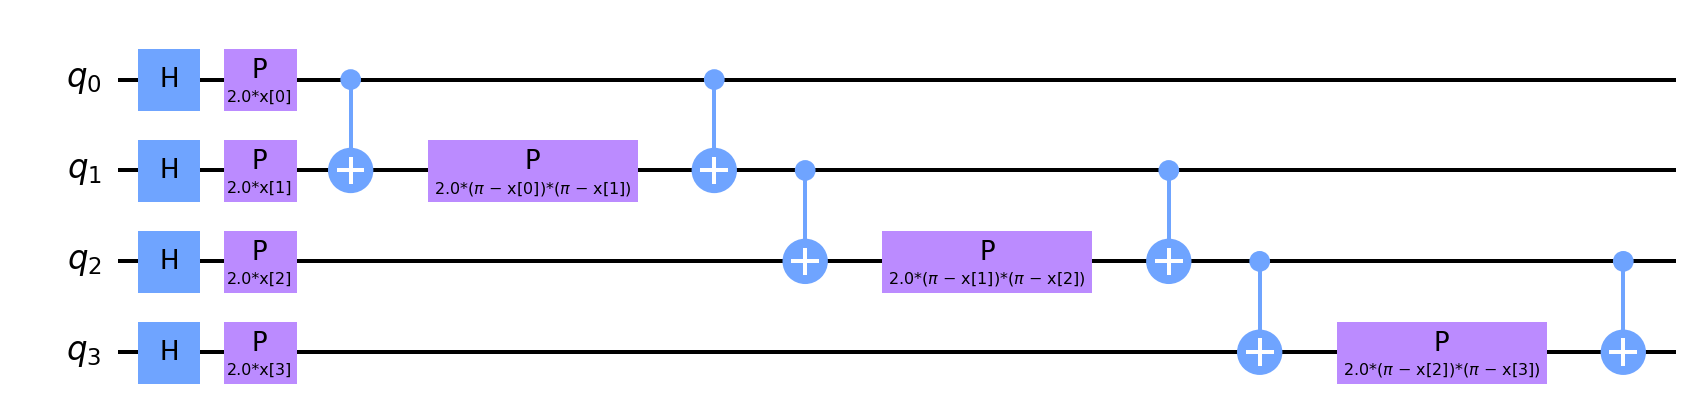

In [173]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(feature_dim, 1, 'linear')
fmap_zz.decompose().draw('mpl', scale=2)

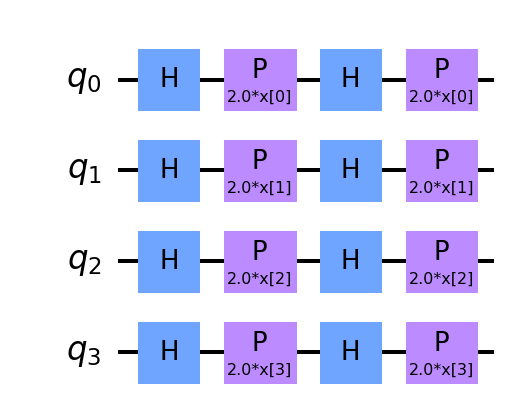

In [186]:
def get_z_feature_map(feature_dim, feature_map_rep):
    return ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep)

fmap_z = get_z_feature_map(feature_dim, 2)
fmap_z.decompose().draw('mpl', scale=2)

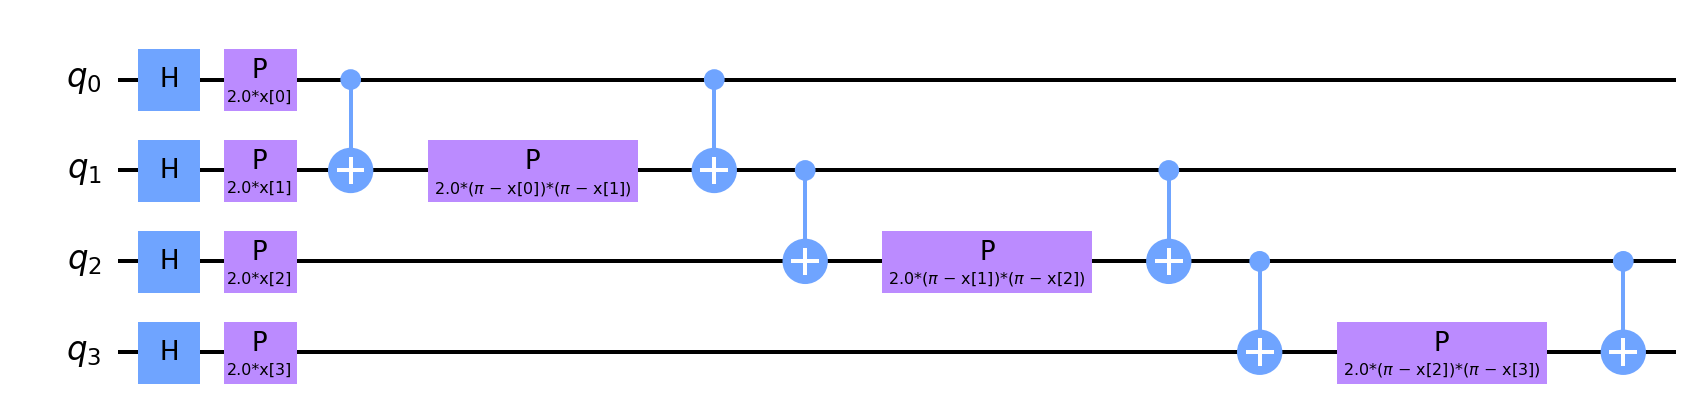

In [215]:
def get_pauli_feature_map(feature_dim, feature_map_rep, ent):
    return PauliFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_pauli = get_pauli_feature_map(feature_dim, 1, 'linear')
fmap_pauli.decompose().draw('mpl', scale=2)

### Angle Embedding

In [9]:
# Define angle embedding with weights


def get_angle_embedding(nb_features, repeat=1):
       
    x_params = ParameterVector('x', nb_features)
    weight_params = ParameterVector('w', 2*nb_features*repeat)
    rotation_params = ParameterVector('m', 2*nb_features*repeat)
    
    model_params = list(rotation_params) + list(weight_params)

    qc = QuantumCircuit(nb_features)
    
    for j in range(repeat):
        for i in range(nb_features):
            qc.rx(x_params[i]*weight_params[2*i+2*nb_features*j] + rotation_params[2*i+2*nb_features*j], i)
            qc.ry(x_params[i]*weight_params[2*i+2*nb_features*j+1] + rotation_params[2*i+2*nb_features*j+1], i)
        
    return qc, x_params, model_params
#



x, ['x[0]', 'x[1]', 'x[2]', 'x[3]']


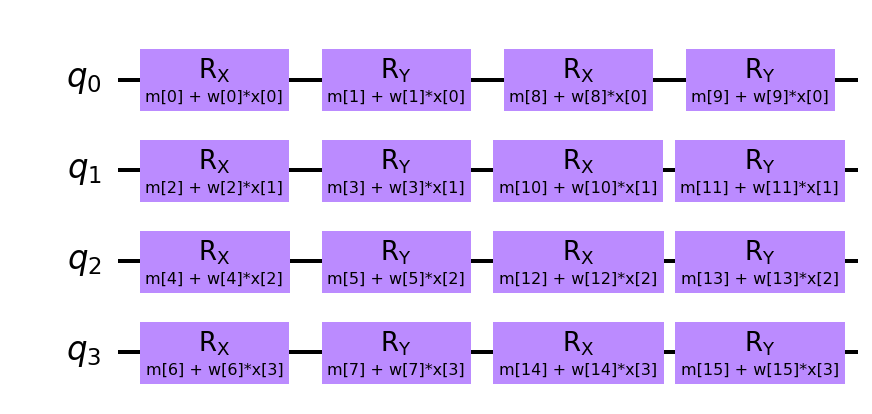

In [10]:
num_features = 4
repeat = 2
angle_embedding, x_params, m_params =get_angle_embedding(num_features, repeat)

print(x_params)
angle_embedding.draw('mpl',scale=2)


In [11]:
a=angle_embedding.parameters
#a[0:3]
#m_params
#x_params
a

ParameterView([ParameterVectorElement(m[0]), ParameterVectorElement(m[1]), ParameterVectorElement(m[2]), ParameterVectorElement(m[3]), ParameterVectorElement(m[4]), ParameterVectorElement(m[5]), ParameterVectorElement(m[6]), ParameterVectorElement(m[7]), ParameterVectorElement(m[8]), ParameterVectorElement(m[9]), ParameterVectorElement(m[10]), ParameterVectorElement(m[11]), ParameterVectorElement(m[12]), ParameterVectorElement(m[13]), ParameterVectorElement(m[14]), ParameterVectorElement(m[15]), ParameterVectorElement(w[0]), ParameterVectorElement(w[1]), ParameterVectorElement(w[2]), ParameterVectorElement(w[3]), ParameterVectorElement(w[4]), ParameterVectorElement(w[5]), ParameterVectorElement(w[6]), ParameterVectorElement(w[7]), ParameterVectorElement(w[8]), ParameterVectorElement(w[9]), ParameterVectorElement(w[10]), ParameterVectorElement(w[11]), ParameterVectorElement(w[12]), ParameterVectorElement(w[13]), ParameterVectorElement(w[14]), ParameterVectorElement(w[15]), ParameterVect

In [13]:
# Define function(s) to generate the encoder circuit
# TODO: implement different designs for data encoding (one function for each)
def encoder_circuit_1(data_x,_):
    """
    Args:
        data_x [np.array] : one data example
        (...)
    Returns:
        encoder_circuit [QuantumCircuit] : encoder circuit for input data example
    """
    encoder_circuit = None
    return encoder_circuit

## 2.2. Prepare Ansatz

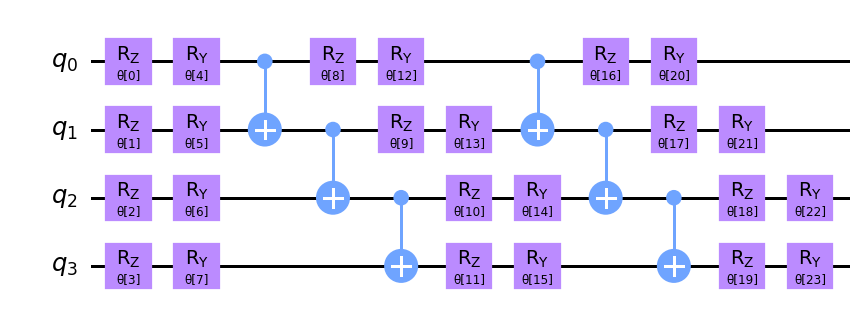

In [12]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(feature_dim, ['rz', 'ry'], 2, 'linear')
ansatz_tl.decompose().draw('mpl', scale=1.5)

In [14]:
# Define function(s) to generate the ansatz
# TODO: implement different ansatz designs (one function for each)
def ansatz_1(n_qubits,_):
    """
    Args:
        n_qubits [int] : number of qubits in the circuit
        (...other necessary args -- e.g., n_layers)
    Returns:
        ansatz [QuantumCircuit] : parameterized ansatz circuit
        ansatz_params [ParameterVector] : parameter vector of the ansatz
    """
    ansatz = None
    ansatz_params = None
    return ansatz, ansatz_params

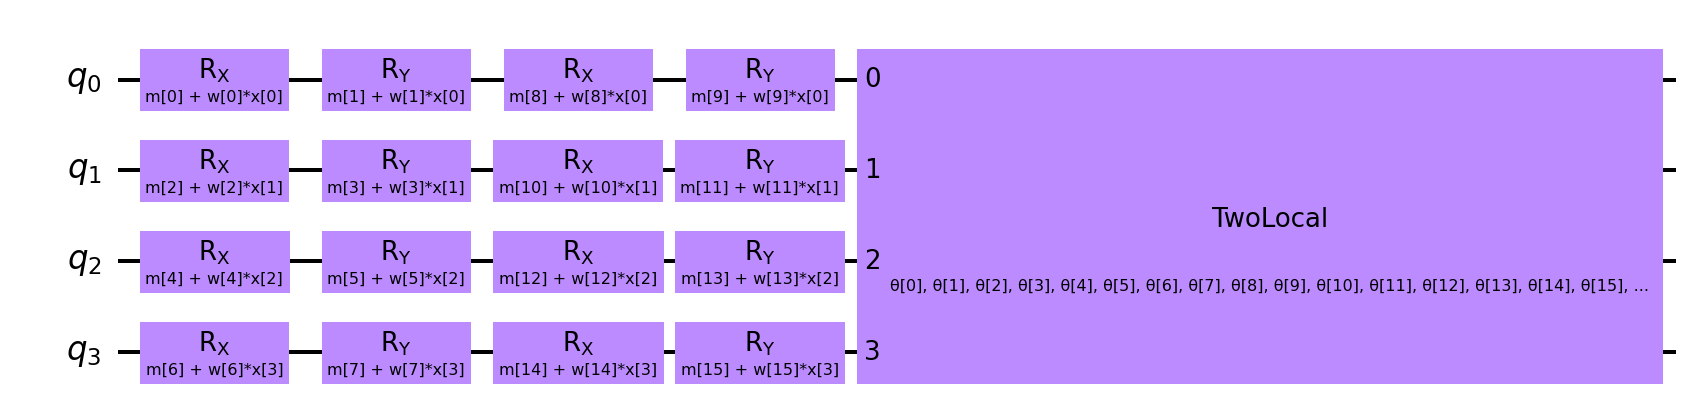

In [15]:
#var_circuit = fmap_zz.compose(ansatz_tl)
#var_circuit = fmap_z.compose(ansatz_tl)
#var_circuit = fmap_pauli.compose(ansatz_tl)
var_circuit = angle_embedding.compose(ansatz_tl)
var_circuit.draw('mpl',scale=2)
#var_circuit.parameters

In [32]:
# TODO: Define function to generate all data encoder circuits (one for each example in the dataset)
# Preparing and cache all encoder circuits to concatenate with ansatz later
def get_all_encoders(data_mat, encoder_func,_):
    """
    Args:
        data_mat [np.array] : of shape (n_samples,n_features) -- matrix containing all examples
        encoder_func [function] : callable to generate encoder circuit (e.g., encoder_circuit_1)
        (...)
    Returns:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
    """
    all_encoders = []
    # pseudo-code: for 'example' in 'data_mat': all_encoders.append(encoder_func('example'))
    return all_encoders

In [34]:
# TODO: Define function to generate all VQC circuits (one for each example)
def get_all_circuits(all_encoders, ansatz_func, _):
    """
    Args:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
        ansatz_func [function] : callable to generate ansatz circuit (e.g., ansatz_1)
        (...)
    Returns:
        all_circuits [list(QuantumCircuit)] : list of all VQC circuits (one for each example)
    """
    all_circuits = []
    return all_circuits

In [16]:
# Create a quantum instance to wrap the execution of circuits
qinstVQC = QuantumInstance(Aer.get_backend('statevector_simulator'))
# or, real hardware backend qinst = ....

In [41]:
# TODO: Define function to calculate target values (can be expectation value or sampling probability)
def get_all_target_vals(all_results,_):
    """
    Args:
        all_results [Result] : output wrapper of all results from executing the VQC circuits
        (...)
    Returns:
        target_val [list(float)] : target values for classification (e.g., expectation value), one for each example
    """
    target_vals = []
    return target_vals

In [ ]:
# TODO: Define function to calculate cost function given all target vals (there can be multiple designs for cost function)
def calculate_cost_function(target_vals,true_labels,_):
    """
    Args:
        target_vals [list(float)] : target values for classification (e.g., expectation value), one for each example
        true_labels [np.array] : vector containing true labels for each example (0 or 1)
        (...)
    Returns:
        cost [float] : total cost for current instance
    """
    cost = 0
    return cost

## 2.3 Prepare measurement

In [17]:
# for multi-class problem this works
#def parity(x, num_classes):
 #   return f"{x:b}".count("1") % num_classes

def parity(x):
    return f"{x:b}".count("1") % 2


# for multi-class problem this needs to be changed
def one_qubit_binary(x):
    return x % 2

## 2.2. Training Implementation

In [18]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP, ADAM

In [ ]:
# TODO: Define training wrapper 
# TODO: Run optimization and plot loss curve
# (...)

## 2.3. Results Discussion

e.g., what method worked best, what did we learn about the problem?

# 3. VQC using Qiskit QNN Classes

In [19]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst_qasm = QuantumInstance(qasm_sim, 2048)

## 3.1. Circuit QNN

In [29]:
angle_embedding.parameters

ParameterView([ParameterVectorElement(m[0]), ParameterVectorElement(m[1]), ParameterVectorElement(m[2]), ParameterVectorElement(m[3]), ParameterVectorElement(m[4]), ParameterVectorElement(m[5]), ParameterVectorElement(m[6]), ParameterVectorElement(m[7]), ParameterVectorElement(w[0]), ParameterVectorElement(w[1]), ParameterVectorElement(w[2]), ParameterVectorElement(w[3]), ParameterVectorElement(w[4]), ParameterVectorElement(w[5]), ParameterVectorElement(w[6]), ParameterVectorElement(w[7]), ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3])])

In [33]:
x_params

ParameterVector(name=x, length=4)

In [30]:
list(ansatz_tl.parameters)+list(m_params)

[ParameterVectorElement(θ[0]),
 ParameterVectorElement(θ[1]),
 ParameterVectorElement(θ[2]),
 ParameterVectorElement(θ[3]),
 ParameterVectorElement(θ[4]),
 ParameterVectorElement(θ[5]),
 ParameterVectorElement(θ[6]),
 ParameterVectorElement(θ[7]),
 ParameterVectorElement(θ[8]),
 ParameterVectorElement(θ[9]),
 ParameterVectorElement(θ[10]),
 ParameterVectorElement(θ[11]),
 ParameterVectorElement(θ[12]),
 ParameterVectorElement(θ[13]),
 ParameterVectorElement(θ[14]),
 ParameterVectorElement(θ[15]),
 ParameterVectorElement(θ[16]),
 ParameterVectorElement(θ[17]),
 ParameterVectorElement(θ[18]),
 ParameterVectorElement(θ[19]),
 ParameterVectorElement(θ[20]),
 ParameterVectorElement(θ[21]),
 ParameterVectorElement(θ[22]),
 ParameterVectorElement(θ[23]),
 ParameterVectorElement(m[0]),
 ParameterVectorElement(m[1]),
 ParameterVectorElement(m[2]),
 ParameterVectorElement(m[3]),
 ParameterVectorElement(m[4]),
 ParameterVectorElement(m[5]),
 ParameterVectorElement(m[6]),
 ParameterVectorElement(m

In [20]:
# qnn with training over data embedding
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=x_params,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=list(ansatz_tl.parameters)+list(m_params),  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 #interpret=parity,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst_qasm)

In [387]:
#num_classes = 2
#qnn = CircuitQNN(circuit=var_circuit,
                 #input_params=fmap_pauli.parameters,
#                 input_params=fmap_z.parameters,
                 #input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
#                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
#                 interpret=one_qubit_binary,
                 #interpret=parity,
#                 output_shape=num_classes,
#                 gradient=None,
#                 quantum_instance=qinst_qasm)

### Forward pass

In [21]:
# The result of the neural network of the shape (output_shape).

#weights = np.random.random(len(ansatz_tl.parameters))
weights=np.random.random(len(list(ansatz_tl.parameters)+list(m_params)))
output = qnn.forward(x_train[1], weights)
print(output.shape)
output

(1, 2)


array([[0.57910156, 0.42089844]])

### Backward pass

In [36]:
_, update = qnn.backward(x_train[0], weights)
print(update)
print(update.shape)

[[[-0.07568359  0.07373047  0.01660156  0.00366211  0.07421875
    0.00097656 -0.04345703 -0.00268555 -0.02563477  0.00708008
   -0.00317383 -0.0065918  -0.23657227  0.12036133  0.01171875
   -0.00366211  0.02148438 -0.00976563  0.0012207   0.01025391
    0.05761719 -0.00366211  0.00585938 -0.01269531 -0.09838867
    0.1730957  -0.07910156 -0.02294922 -0.01074219 -0.04638672
    0.00585938 -0.00439453  0.18938879 -0.30744934 -0.25476909
   -0.10172759  0.02366333  0.07714246  0.00855132 -0.01900293]
  [ 0.07568359 -0.07373047 -0.01660156 -0.00366211 -0.07421875
   -0.00097656  0.04345703  0.00268555  0.02563477 -0.00708008
    0.00317383  0.0065918   0.23657227 -0.12036133 -0.01171875
    0.00366211 -0.02148438  0.00976563 -0.0012207  -0.01025391
   -0.05761719  0.00366211 -0.00585938  0.01269531  0.09838867
   -0.1730957   0.07910156  0.02294922  0.01074219  0.04638672
   -0.00585938  0.00439453 -0.18938879  0.30744934  0.25476909
    0.10172759 -0.02366333 -0.07714246 -0.00855132  0.

### 3.1.1. Prepare encoder, ansatz, and interpreter

In [22]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [474]:
print(y_train[0])
print(y_train_1h[0])

print(len(y_train))
      
print(y_train[4])
print(y_train_1h[4])

1.0
[0. 1.]
137
0.0
[1. 0.]


In [23]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [24]:
#np.random.random((len(ansatz_tl.parameters),))
np.random.random((len(list(ansatz_tl.parameters)+list(m_params))))

#len(ansatz_tl.parameters)

array([0.91539521, 0.23399954, 0.95919556, 0.74762898, 0.74350281,
       0.86212809, 0.18434292, 0.23325278, 0.50018338, 0.64823069,
       0.38449572, 0.35049559, 0.32418291, 0.6620122 , 0.61018142,
       0.07481881, 0.10691876, 0.29480106, 0.38143781, 0.60370752,
       0.57637783, 0.51994002, 0.97668537, 0.13834507, 0.96548932,
       0.39021997, 0.95265438, 0.62956394, 0.50032858, 0.39932135,
       0.37013429, 0.94892436, 0.97638461, 0.20424297, 0.64138637,
       0.28926162, 0.6627045 , 0.57024418, 0.38408321, 0.0495969 ,
       0.58623262, 0.27947148, 0.2681332 , 0.50870753, 0.45068225,
       0.48700613, 0.41347263, 0.49049486, 0.76961642, 0.65532215,
       0.04880127, 0.23588598, 0.17798261, 0.66545965, 0.18403404,
       0.95614032])

### 3.1.2. Training Implementation

In [25]:
max_itr = 60

spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []

#initial_point = np.random.random((len(ansatz_tl.parameters),))
initial_point = np.random.random((len(list(ansatz_tl.parameters)+list(m_params))))

vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(), #log of ...
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train]) # normalizing or not ... can depend on the data set you can try both
vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 136.21001898713382
6 - 132.55098261976644
9 - 146.04189044892843
12 - 135.98163322076374
15 - 133.42880237758135
18 - 132.98753474932317
21 - 132.21463787274203
24 - 118.90129465758915
27 - 110.91641108000746
30 - 110.47273837810278
33 - 110.4736009703488
36 - 110.3595592623781
39 - 110.45136336352667
42 - 107.2197011097384
45 - 106.16882584481804
48 - 106.0707842442461
51 - 100.66160744380552
54 - 94.74240255013035
57 - 93.17456122175017
60 - 92.58188248881041
63 - 92.25181578400733
66 - 91.80865248263716
69 - 90.63878020232497
72 - 90.60306632456806
75 - 89.2956034092845
78 - 89.31529692875677
81 - 88.68365279426831
84 - 86.79602867453637
87 - 86.40251757694108
90 - 86.74315238371386
93 - 86.46260944953004
96 - 86.66118125305812
99 - 86.05874852503035
102 - 84.24847433938571
105 - 84.95719213132307
108 - 83.59593862653051
111 - 83.3581130223256
114 - 81.10961002765316
117 - 81.68667011253828
120 - 81.58813658979841
123 - 80.97147548181442
126 - 80.57269092389167
129 - 81.08892589

In [26]:
score_train_norm = vqc.score(x_train_norm, y_train_1h)
print(f'Score on the normalized train set {score_train_norm}')

x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test]) # normalizing or not ... can depend on the data set you can try both
score_test_norm = vqc.score(x_test_norm, y_test_1h)
print(f'Score on the normalized test set {score_test_norm}')

Score on the normalized train set 0.9197080291970803
Score on the normalized test set 0.91417004048583


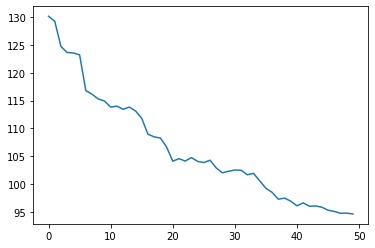

In [517]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

## 3.2. Opflow QNN

### 3.2.1. Define measurement operator and circuit state function

### 3.1.2. Training Implementation

### 3.1.3. Results Discussion

# 4. Quantum Support Vector Machine (if have time)

## 4.1. Define feature map(s) (kernel)

## 4.2. Prepare all circuits and obtain kernel matrix

## 4.3. Training Implementation (using sci-kit's SVC class)

## 4.4. Results Discussion

# 5. Classical Methods (if have time)

## 5.1. Classical SVM

## 5.2. Classical Neural Network

# 5. Summary & Conclusion

Summarize and reflect on all aspects and observations of the project. Did we end up with a decent classifier?